# AI28 - Machine Learning 

GLANDIER Quentin : GI04

## TP N° 3 - Apprentissage supervisé : classification binaire

### 1. Importations des librairies et lecture des données

In [66]:
# INIT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

# 2. Charger les données et les enregistrer dans une structure dataframe de Pandas.
data = pd.read_csv("framingham.csv")

def p(*pargs):
    print("*"*150)
    def f(x):
        if isinstance(x, str):
            return f"\033[1;34m{x}\033[0m"
        else:
            return x
    pargs = tuple(map(f, pargs))
    print(*pargs)

### 2 Analyse exploratoire des données

In [67]:
# 1. Préciser la variable d’intérêt
p("1. Préciser la variable d’intérêt")
print("Variable cible: TenYearCHD")
print("Variables explicatives: ")
for column in data.columns:
    if column == "TenYearCHD": continue
    print(column)
# 2. Quelles sont les dimensions de votre dataframe ?
dimensions = data.shape
p("2. Dimensions du dataframe :", dimensions)

# 3. Indiquer le type de chacune des variables.
types = data.dtypes
p("3. Types de chaque variable :\n", types)

# 4. Afficher un résumé statistique des variables numériques.
stat_summary = data.describe()
p("4. Résumé statistique des variables numériques :\n", stat_summary)

# 5. Donner la matrice de corrélation pour les variables numériques. Commenter.
correlation_matrix = data.corr()
p("5. Matrice de corrélation :\n", correlation_matrix)

# 6. Donner les corrélations entre la variable cible et les autres variables numériques. Commenter.
target_correlation = correlation_matrix['TenYearCHD'].drop('TenYearCHD')
p("6. Corrélations avec 'TenYearCHD' :\n", target_correlation)


******************************************************************************************************************************************************
1. Préciser la variable d’intérêt
Variable cible: TenYearCHD
Variables explicatives: 
male
age
education
currentSmoker
cigsPerDay
BPMeds
prevalentStroke
prevalentHyp
diabetes
totChol
sysBP
diaBP
BMI
heartRate
glucose
******************************************************************************************************************************************************
2. Dimensions du dataframe : (4240, 16)
******************************************************************************************************************************************************
3. Types de chaque variable :
 male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol         

******************************************************************************************************************************************************
7. Visualiser les nuages de points des variables numériques et de la variable cible


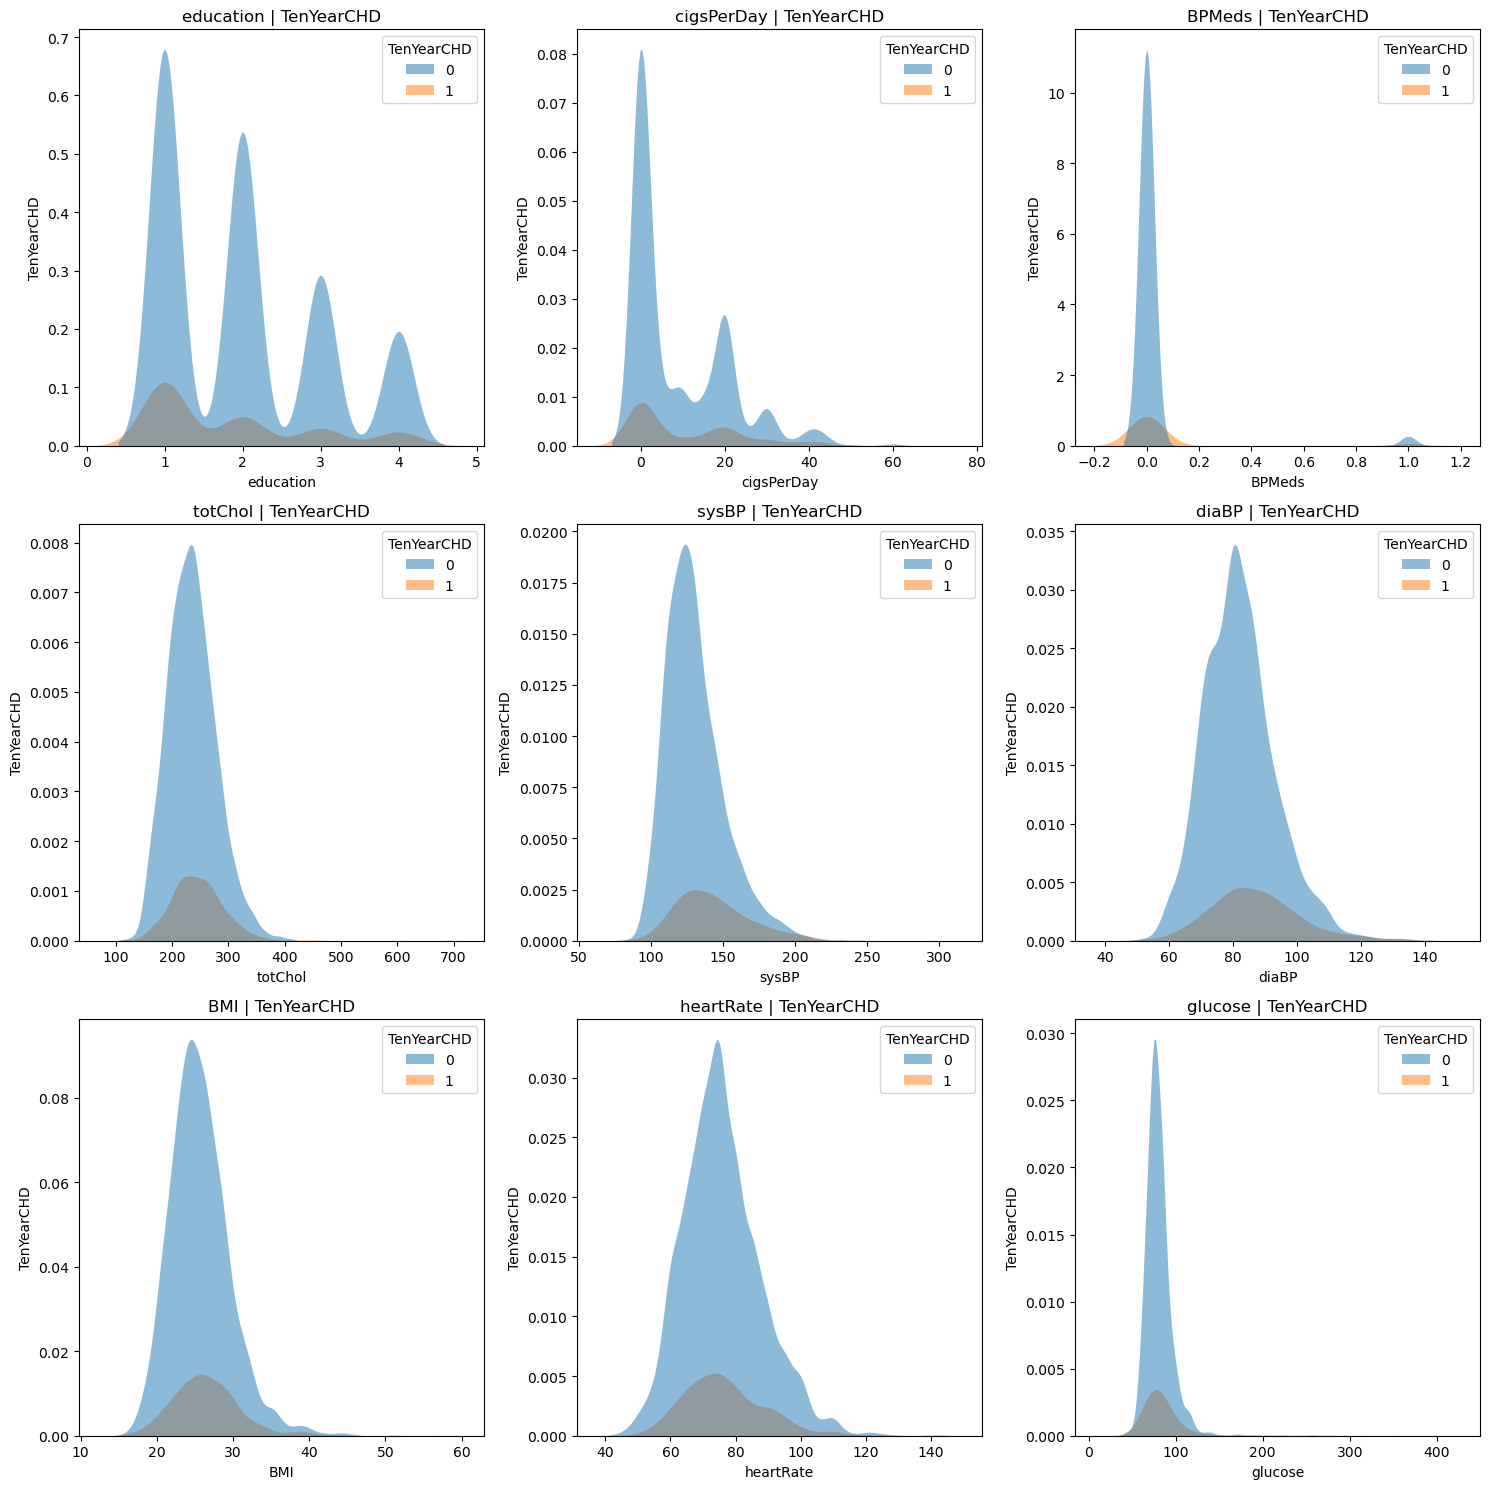

In [68]:
def plot_multiple(data, target_variable, variables_to_plot, n_cols):
    # Déterminer le nombre de lignes de subplots en fonction du nombre de variables et de colonnes
    n_vars = variables_to_plot.shape[1]
    n_rows = (n_vars + n_cols - 1) // n_cols  # Calcul du nombre de lignes nécessaires

    # Créer une figure avec n_cols colonnes et n_rows lignes de subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

    # Assurez-vous que 'axes' est une matrice 2D même s'il y a une seule ligne ou une seule colonne
    if n_rows == 1 and n_cols == 1:
        axes = [[axes]]
    elif n_rows == 1:
        axes = [axes]
    elif n_cols == 1:
        axes = [[ax] for ax in axes]

    # Aplatir les axes pour une itération plus facile
    axes_flat = [ax for row in axes for ax in row]

    # Plot chaque variable dans un subplot
    for i, var in enumerate(variables_to_plot.columns):
        sns.kdeplot(ax=axes_flat[i], data=data, x=var, hue=target_variable, fill=True, alpha=0.5, linewidth=0)
        axes_flat[i].set_title(f"{var} | {target_variable}")
        axes_flat[i].set_xlabel(var)
        axes_flat[i].set_ylabel(target_variable)

    # Supprimer les subplots inutilisés
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    # Afficher la figure avec tous les subplots
    plt.tight_layout()
    plt.show()


p("7. Visualiser les nuages de points des variables numériques et de la variable cible")
plot_multiple(data, target_variable='TenYearCHD', n_cols=3, variables_to_plot=data.select_dtypes(include=['float64']))

******************************************************************************************************************************************************
8. Visualiser les nuages de points des variables catégorielles et de la variable cible


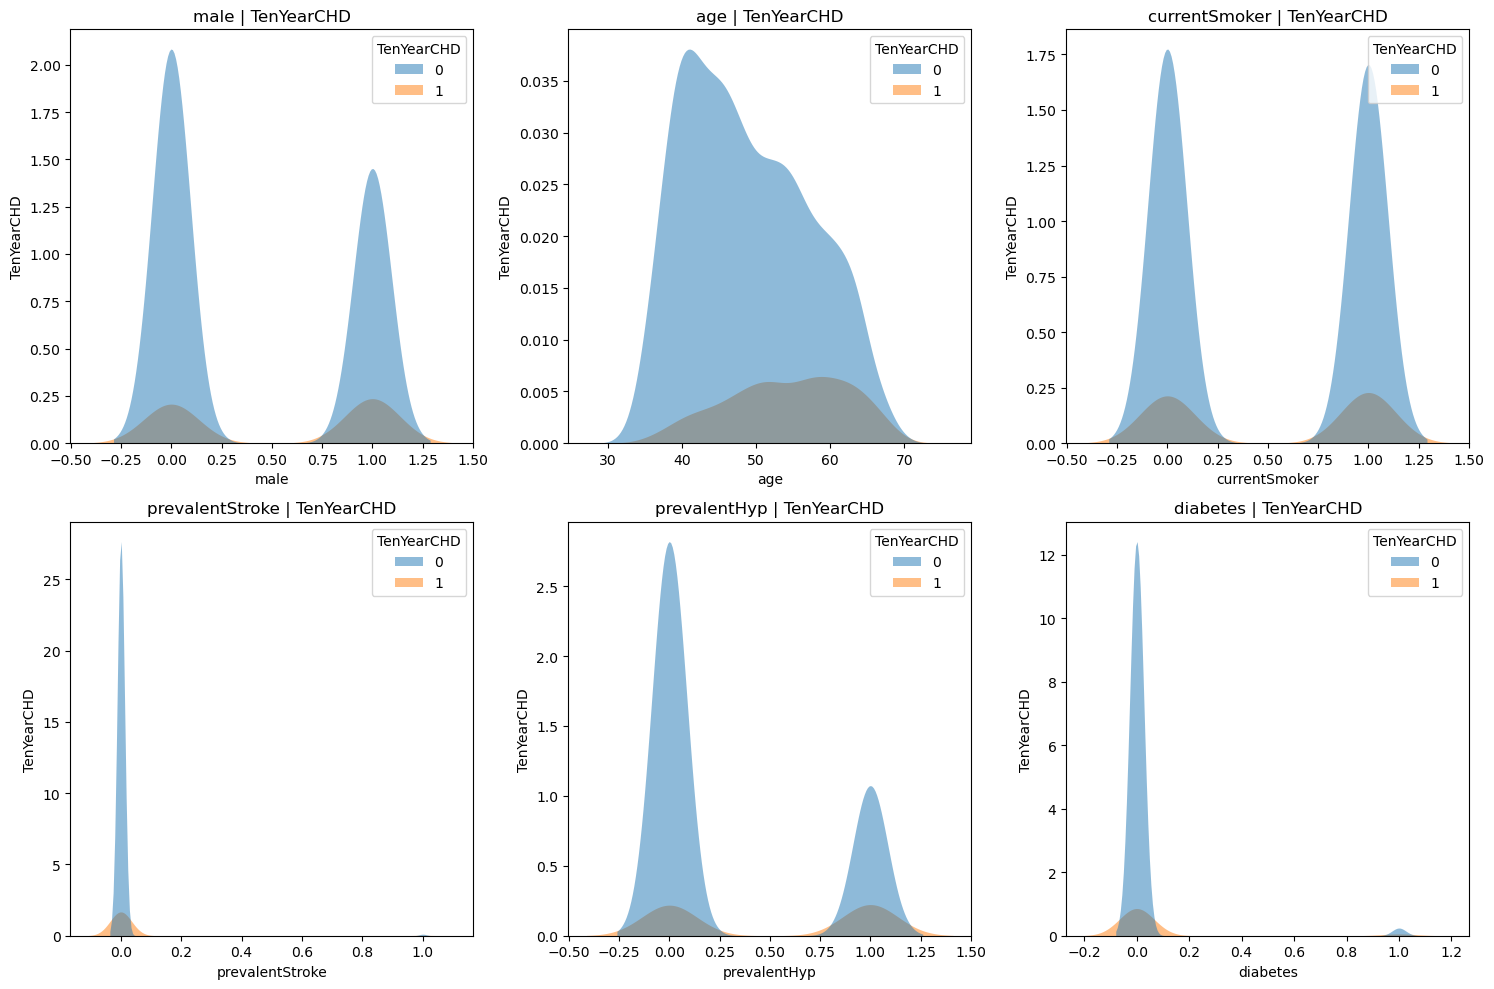

In [69]:
p("8. Visualiser les nuages de points des variables catégorielles et de la variable cible")
plot_multiple(data, target_variable='TenYearCHD', n_cols=3, variables_to_plot=data.select_dtypes(include=['int64']).drop('TenYearCHD', axis=1))

### 3 Pré-traitement des données

******************************************************************************************************************************************************
1. Visualiser les valeurs manquantes des variables, si elles existent.


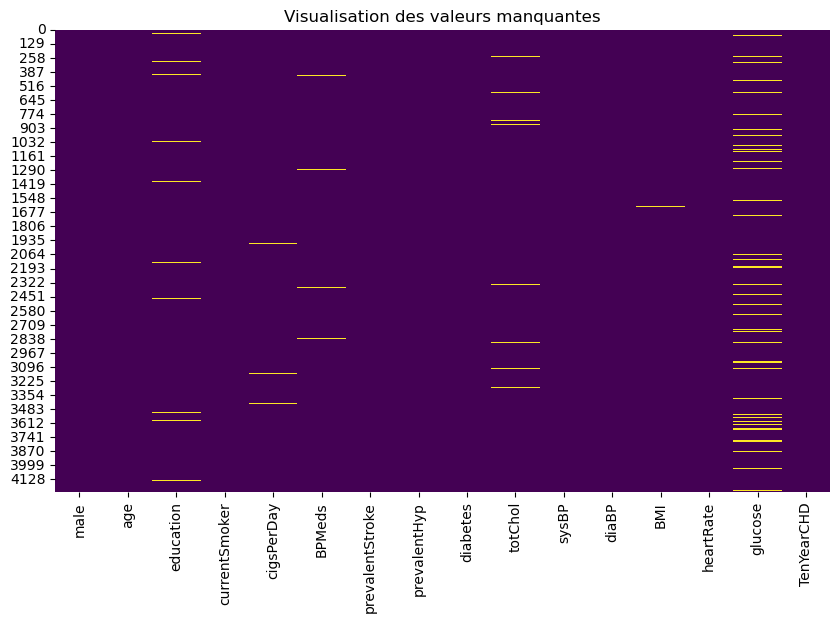

******************************************************************************************************************************************************
2. Calculez les pourcentages des valeurs manquantes de chaque variable. Il est préférable d’ordonner ces pourcentages.
Pourcentage des valeurs manquantes pour chaque variable (en ordre décroissant) :
glucose            9.150943
education          2.476415
BPMeds             1.250000
totChol            1.179245
cigsPerDay         0.683962
BMI                0.448113
heartRate          0.023585
male               0.000000
age                0.000000
currentSmoker      0.000000
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
sysBP              0.000000
diaBP              0.000000
TenYearCHD         0.000000
dtype: float64
******************************************************************************************************************************************************
3. Traiter les valeurs manquantes. 

In [70]:
p("1. Visualiser les valeurs manquantes des variables, si elles existent.")
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Visualisation des valeurs manquantes")
plt.show()

p("2. Calculez les pourcentages des valeurs manquantes de chaque variable. Il est préférable d’ordonner ces pourcentages.")
missing_percentage = data.isnull().mean() * 100
missing_percentage = missing_percentage.sort_values(ascending=False)
print("Pourcentage des valeurs manquantes pour chaque variable (en ordre décroissant) :")
print(missing_percentage)

p("3. Traiter les valeurs manquantes. Quelle stratégie adoptez-vous ?")
print("    -> Remplacer les valeurs numériques manquantes par la moyenne et les catégorielles par la valeur la plus fréquente (mode)")
for column in data.columns:
    if data[column].dtype == 'float64' or data[column].dtype == 'int64':
        data[column].fillna(data[column].mean(), inplace=True)
    else:
        data[column].fillna(data[column].mode()[0], inplace=True)

p("4. Traiter les valeurs catégorielles. Quelle stratégie adoptez-vous ?")
print("    -> Utiliser l'encodage one-hot pour transformer les variables catégorielles en variables binaires.")
data = pd.get_dummies(data)

p("5. Utiliser une méthode pour normaliser les données numériques.")
print("    -> Utiliser la méthode de la standardisation (z-score) pour normaliser les données numériques.")
scaler = StandardScaler()
numerical_vars = data.select_dtypes(include=['float64']).columns
data[numerical_vars] = scaler.fit_transform(data[numerical_vars])

p("6. Séparer les données de travail en des données d’apprentissage et de test.")
print("    -> Utiliser la fonction train_test_split pour diviser les données en ensembles d'apprentissage et de test.")
X_train, X_test, y_train, y_test = train_test_split(data.drop('TenYearCHD', axis=1), data['TenYearCHD'], test_size=0.2, random_state=42)

p("Normaliser les données de test et d'apprentissage.")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



### 4 Modélisation + Évaluation

******************************************************************************************************************************************************
Étape 1 : Entraîner le modèle de régression logistique
******************************************************************************************************************************************************
Étape 2 : Évaluer le modèle sur les données d’apprentissage
Accuracy sur les données d'apprentissage : 0.8555424528301887
Rapport de classification sur les données d'apprentissage :
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2871
           1       0.74      0.09      0.16       521

    accuracy                           0.86      3392
   macro avg       0.80      0.54      0.54      3392
weighted avg       0.84      0.86      0.80      3392

**************************************************************************************************************************************

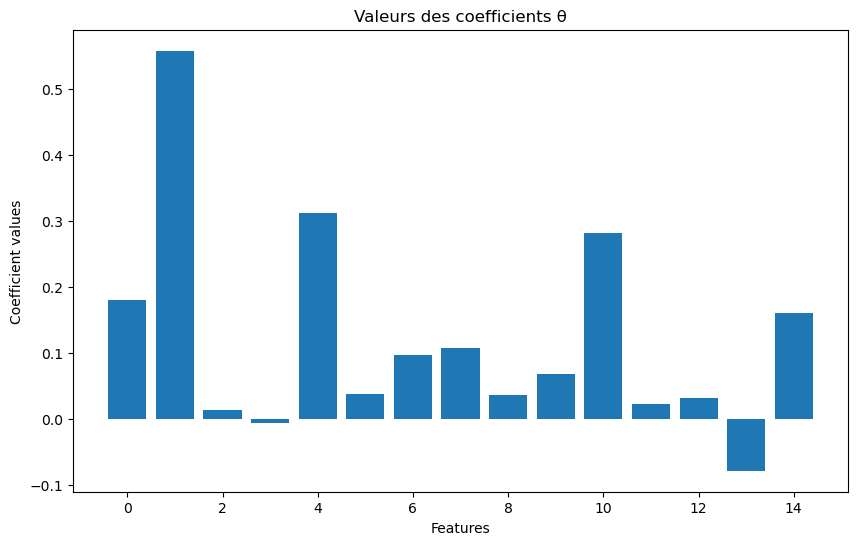

In [74]:
p("Étape 1 : Entraîner le modèle de régression logistique")
reglog = LogisticRegression()
reglog.fit(X_train_scaled, y_train)

p("Étape 2 : Évaluer le modèle sur les données d’apprentissage")
y_train_pred = reglog.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy sur les données d'apprentissage :", train_accuracy)
print("Rapport de classification sur les données d'apprentissage :")
print(classification_report(y_train, y_train_pred))

p("Étape 3 : Évaluer le modèle sur les données de test")
y_test_pred = reglog.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy sur les données de test :", test_accuracy)
print("Rapport de classification sur les données de test :")
print(classification_report(y_test, y_test_pred))

p("Étape 4 : Tracer les valeurs des coefficients")
coefficients = reglog.coef_[0]
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients)
plt.xlabel('Features')
plt.ylabel('Coefficient values')
plt.title('Valeurs des coefficients θ')
plt.show()

### 4.2 Régression logistique pénalisée

In [75]:
p("Étape 1 : Entraîner les modèles de régression logistique pénalisée avec normalisation et plus d'itérations")
logregRidge = LogisticRegression(penalty='l2', C=1.0, random_state=42, max_iter=1000)
logregLasso = LogisticRegression(penalty='l1', solver='saga', C=1.0, random_state=42, max_iter=1000)
logregElast = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0, random_state=42, max_iter=1000)

p("Entraîner les modèles")
logregRidge.fit(X_train_scaled, y_train)
logregLasso.fit(X_train_scaled, y_train)
logregElast.fit(X_train_scaled, y_train)

p("Étape 2 : Évaluer les modèles sur les données d’apprentissage")
models = {'Ridge':logregRidge, 'Lasso':logregLasso, 'ElasticNet':logregElast}

for name, model in models.items():
    y_train_pred = model.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Accuracy sur les données d'apprentissage pour {name} :", train_accuracy)
    print(f"Rapport de classification sur les données d'apprentissage pour {name} :")
    print(classification_report(y_train, y_train_pred))

p("Étape 3 : Évaluer les modèles sur les données de test")
for name, model in models.items():
    y_test_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy sur les données de test pour {name} :", test_accuracy)
    print(f"Rapport de classification sur les données de test pour {name} :")
    print(classification_report(y_test, y_test_pred))

p("Étape 4 : Comparer avec la régression logistique standard")
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_test_pred_standard = logreg.predict(X_test_scaled)
test_accuracy_standard = accuracy_score(y_test, y_test_pred_standard)
print("Accuracy sur les données de test pour la régression logistique standard :", test_accuracy_standard)
print("Rapport de classification pour la régression logistique standard :")
print(classification_report(y_test, y_test_pred_standard))

p("Étape 5 : Optimiser le coefficient de régularisation")
alphas = np.logspace(-3, 1, 20)

for model, name in zip([LogisticRegression(penalty='l2', random_state=42, max_iter=1000),
                        LogisticRegression(penalty='l1', solver='saga', random_state=42, max_iter=1000),
                        LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42, max_iter=1000)], 
                       models.keys()):
    gridscv = GridSearchCV(model, dict(C=alphas), cv=5)
    gridscv.fit(X_train_scaled, y_train)
    print(f"{name} best_params:", gridscv.best_params_)

******************************************************************************************************************************************************
Étape 1 : Entraîner les modèles de régression logistique pénalisée avec normalisation et plus d'itérations
******************************************************************************************************************************************************
Entraîner les modèles
******************************************************************************************************************************************************
Étape 2 : Évaluer les modèles sur les données d’apprentissage
Accuracy sur les données d'apprentissage pour Ridge : 0.8555424528301887
Rapport de classification sur les données d'apprentissage pour Ridge :
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2871
           1       0.74      0.09      0.16       521

    accuracy                           0.86     

In [76]:
p("6. Commentez les résultats obtenus. Quel algorithme recommanderiez-vous d’utiliser ? Avec quelles garanties de résultat ?")
print("""
      Les résultats montrent que les modèles pénalisés (Ridge, Lasso et ElasticNet) obtiennent une bonne accuracy (environ 85.6%) sur les données d'apprentissage. 
      Cependant, les métriques pour la classe minoritaire (classe 1) indiquent que ces modèles ont des difficultés à bien classifier cette classe. 
      Cela se voit particulièrement dans le faible recall (0.09) et F1-score (0.16) pour la classe 1.
      
      Algorithme recommandé :
       'Ridge Regression' semble être légèrement préféré en termes de stabilité et de généralisation par rapport à Lasso et ElasticNet.
      Garantie de résultats :
        Sur-apprentissage : La pénalisation aide à réduire le risque de sur-apprentissage, surtout avec la régularisation L2 (Ridge).
      """)

******************************************************************************************************************************************************
6. Commentez les résultats obtenus. Quel algorithme recommanderiez-vous d’utiliser ? Avec quelles garanties de résultat ?

      Les résultats montrent que les modèles pénalisés (Ridge, Lasso et ElasticNet) obtiennent une bonne accuracy (environ 85.6%) sur les données d'apprentissage. 
      Cependant, les métriques pour la classe minoritaire (classe 1) indiquent que ces modèles ont des difficultés à bien classifier cette classe. 
      Cela se voit particulièrement dans le faible recall (0.09) et F1-score (0.16) pour la classe 1.
      
      Algorithme recommandé :
       'Ridge Regression' semble être légèrement préféré en termes de stabilité et de généralisation par rapport à Lasso et ElasticNet.
      Garantie de résultats :
        Sur-apprentissage : La pénalisation aide à réduire le risque de sur-apprentissage, surtout avec la ré